### 在gbdt中使用focal loss

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import os
from datetime import timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.misc import derivative
import seaborn as sns
sns.set()

def draw_roc_and_calculate_auc(models, modelnames, colors, X_test, y_test):  # 把models的roc曲线(和auc值)画到一张图
    N = len(models)  # 输入的是N个模型
    y_test_pred_prob = [0] * N  # 初始化一下列表（感觉这么初始化有点丑？）
    auc = [0] * N
    FPR = [0] * N
    TPR = [0] * N
    plt.figure()
    for i in range(N):
        y_test_pred_prob[i] = models[i].predict(X_test)
        auc[i] = roc_auc_score(y_test, y_test_pred_prob[i], average='macro')
        FPR[i], TPR[i], _ = roc_curve(y_test, y_test_pred_prob[i])
        plt.plot(FPR[i], TPR[i], color=colors[i],alpha=0.5, label=modelnames[i] + ':AUC=%.4f' % auc[i])
    plt.plot([0, 1], [0, 1], '--', color='black')  # diagonal line
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


def draw_confusion_metrics(model, modelname, X_test, y_test):  # 把model的混淆矩阵画出来  #这个同时写很多的话不知道怎么安排画布就没写sos
    plt.figure()

    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

    # # y_test_pred = model.predict(X_test)  # 上面那行有时候会报错，如果模型直接是classifier用这行就行
    # y_test_pred = model.predict_proba(X_test)[:, 1]  # 取第二列 正的概率，根据每个人的数据不同而不同!
    # y_test_pred = np.around(y_test_pred, 0).astype(int)

    c_matrix = confusion_matrix(y_test, y_test_pred)
    ax = sns.heatmap(c_matrix, annot=True, fmt="d",
                     xticklabels=['0', '1'],
                     yticklabels=['0', '1'],  # 应该没写反吧
                     cbar=False, cmap='Blues')
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    plt.title(modelname)
    plt.show()

In [2]:
####导入数据
df = pd.read_csv("E:/Desktop/train_after_FeatureEngineer.csv")

df_X = df.drop(['target', 'id'], axis=1)
X = df_X.loc[:, :]
Y = df.loc[:, 'target']
X = X.to_numpy()
y = Y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3,random_state=123)

lgbtrain = lgb.Dataset(X_train, y_train, free_raw_data=True)
lgbeval = lgb.Dataset(X_test, y_test)

In [3]:
# 定义focal loss 损失函数
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
    a, g = alpha, gamma
    y_true = dtrain.label

    def fl(x, t):
        p = 1 / (1 + np.exp(-x))
        return -(a * t + (1 - a) * (1 - t)) * ((1 - (t * p + (1 - t) * (1 - p))) ** g) * (
                t * np.log(p) + (1 - t) * np.log(1 - p))

    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess


def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
    a, g = alpha, gamma
    y_true = dtrain.label
    p = 1 / (1 + np.exp(-y_pred))
    loss = -(a * y_true + (1 - a) * (1 - y_true)) * ((1 - (y_true * p + (1 - y_true) * (1 - p))) ** g) * (
            y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    return 'focal_loss', np.mean(loss), False

In [4]:
# 设定参数
params= {
    'boosting_type': 'gbdt',
    'objective': 'binary',
#     'metric': {'auc'},
    'metric': 'custom',
    #'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
}

#focal loss
focal_loss0 = lambda x,y: focal_loss_lgb(x, y, 0.5, 0.)
focal_loss1 = lambda x,y: focal_loss_lgb(x, y, 0.95, 0.)
focal_loss2 = lambda x,y: focal_loss_lgb(x, y, 0.95, 1.)
focal_loss3 = lambda x,y: focal_loss_lgb(x, y, 0.95, 2.)
focal_loss4 = lambda x,y: focal_loss_lgb(x, y, 0.95, 4.)
focal_loss5 = lambda x,y: focal_loss_lgb(x, y, 0.95, 8.)

In [5]:
def f_auc(probas_pred, y_true):
    labels=y_true.get_label()
    score = roc_auc_score(labels,probas_pred, average='macro')
    return "auc", score, True

print("---------no focal loss-----------")
model1 = lgb.train(params,lgbtrain,num_boost_round=150,valid_sets=[lgbeval],feval=f_auc, verbose_eval=10,early_stopping_rounds=20)

# print("---------focal loss: alpha=0.5,gamma=0-----------")
# model2 = lgb.train(params,lgbtrain,num_boost_round=150,valid_sets=[lgbeval],fobj=focal_loss0,feval=f_auc,verbose_eval=10,early_stopping_rounds=10)

print("---------focal loss: alpha=0.95,gamma=0-----------")
model3 = lgb.train(params,lgbtrain,num_boost_round=150,valid_sets=[lgbeval],fobj=focal_loss1,feval=f_auc, verbose_eval=10,early_stopping_rounds=20)

print("---------focal loss: alpha=0.95,gamma=1-----------")
model4 = lgb.train(params,lgbtrain,num_boost_round=150,valid_sets=[lgbeval],fobj=focal_loss2, feval=f_auc,verbose_eval=10,early_stopping_rounds=20)

print("---------focal loss: alpha=0.95,gamma=2-----------")
model5 = lgb.train(params,lgbtrain,num_boost_round=150,valid_sets=[lgbeval],fobj=focal_loss3,feval=f_auc, verbose_eval=10,early_stopping_rounds=20)

print("---------focal loss: alpha=0.95,gamma=4-----------")
model6 = lgb.train(params,lgbtrain,num_boost_round=150,valid_sets=[lgbeval],fobj=focal_loss4,feval=f_auc, verbose_eval=10,early_stopping_rounds=20)

print("---------focal loss: alpha=0.95,gamma=8-----------")
model7 = lgb.train(params,lgbtrain,num_boost_round=150,valid_sets=[lgbeval],fobj=focal_loss5, feval=f_auc,verbose_eval=10,early_stopping_rounds=20)

---------no focal loss-----------


D:\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.61864
[20]	valid_0's auc: 0.623683
[30]	valid_0's auc: 0.628485
[40]	valid_0's auc: 0.629112
[50]	valid_0's auc: 0.63055
[60]	valid_0's auc: 0.630787
[70]	valid_0's auc: 0.630931
[80]	valid_0's auc: 0.631389
[90]	valid_0's auc: 0.631077
[100]	valid_0's auc: 0.630794
Early stopping, best iteration is:
[82]	valid_0's auc: 0.631539
---------focal loss: alpha=0.95,gamma=0-----------
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warnin

D:\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.621735
[20]	valid_0's auc: 0.625954
[30]	valid_0's auc: 0.629544
[40]	valid_0's auc: 0.630566
[50]	valid_0's auc: 0.631255
[60]	valid_0's auc: 0.631699
[70]	valid_0's auc: 0.631881
[80]	valid_0's auc: 0.632224
[90]	valid_0's auc: 0.632077
Early stopping, best iteration is:
[79]	valid_0's auc: 0.632278
---------focal loss: alpha=0.95,gamma=1-----------
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Using self-defined objective function


D:\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.621122
[20]	valid_0's auc: 0.625322
[30]	valid_0's auc: 0.629433
[40]	valid_0's auc: 0.63059
[50]	valid_0's auc: 0.631506
[60]	valid_0's auc: 0.632054
[70]	valid_0's auc: 0.632092
[80]	valid_0's auc: 0.632488
[90]	valid_0's auc: 0.632229
[100]	valid_0's auc: 0.631488
Early stopping, best iteration is:
[80]	valid_0's auc: 0.632488
---------focal loss: alpha=0.95,gamma=2-----------
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Using self-defined objective function


D:\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.621873
[20]	valid_0's auc: 0.625314
[30]	valid_0's auc: 0.629473
[40]	valid_0's auc: 0.630804
[50]	valid_0's auc: 0.631241
[60]	valid_0's auc: 0.632393
[70]	valid_0's auc: 0.632848
[80]	valid_0's auc: 0.633467
[90]	valid_0's auc: 0.633208
[100]	valid_0's auc: 0.632789
Early stopping, best iteration is:
[81]	valid_0's auc: 0.633532
---------focal loss: alpha=0.95,gamma=4-----------
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Using self-defined objective function


D:\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.621789
[20]	valid_0's auc: 0.625354
[30]	valid_0's auc: 0.629209
[40]	valid_0's auc: 0.629978
[50]	valid_0's auc: 0.631003
[60]	valid_0's auc: 0.631512
[70]	valid_0's auc: 0.6319
[80]	valid_0's auc: 0.632059
[90]	valid_0's auc: 0.632277
[100]	valid_0's auc: 0.631731
Early stopping, best iteration is:
[85]	valid_0's auc: 0.632495
---------focal loss: alpha=0.95,gamma=8-----------
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Using self-defined objective function


D:\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.622186
[20]	valid_0's auc: 0.62588
[30]	valid_0's auc: 0.62989
[40]	valid_0's auc: 0.630902
[50]	valid_0's auc: 0.631799
[60]	valid_0's auc: 0.632152
[70]	valid_0's auc: 0.632413
[80]	valid_0's auc: 0.632014
Early stopping, best iteration is:
[66]	valid_0's auc: 0.632477


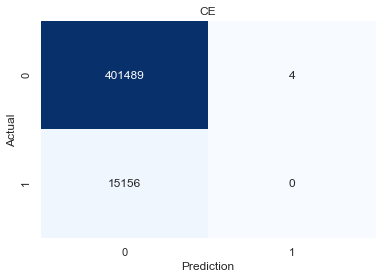

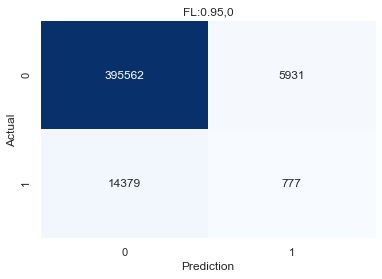

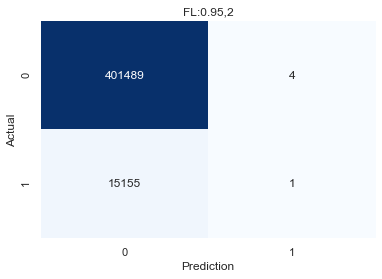

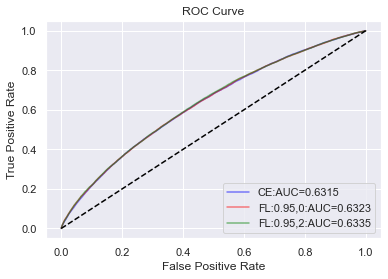

In [8]:
#
draw_confusion_metrics(model=model1, modelname='CE', X_test=X_test, y_test=y_test)
draw_confusion_metrics(model=model3, modelname='FL:0.95,0', X_test=X_test, y_test=y_test)
draw_confusion_metrics(model=model5, modelname='FL:0.95,2', X_test=X_test, y_test=y_test)

#
draw_roc_and_calculate_auc(models=[model1, model3,model5], modelnames=['CE', 'FL:0.95,0' ,'FL:0.95,2'], colors=['blue', 'red','green'],
                           X_test=X_test, y_test=y_test)


### 可以看出，在gdbt中focal loss虽然对真1类的区分有一定帮助，但也带来了较大误分，对auc值影响不大